<a href="https://colab.research.google.com/github/cleodecker/tcc/blob/main/RNN_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


In [4]:
# Carregar os dados
url = "https://raw.githubusercontent.com/cleodecker/tcc/main/df_all.csv"
cache_file = "df_all.csv"

if not os.path.exists(cache_file):
    df = pd.read_csv(url)
    df.to_csv(cache_file, index=False)
    print("Dataset baixado do GitHub e salvo em cache")
else:
    df = pd.read_csv(cache_file)
    print("Dataset carregado do cache local")
print(f'Dataset carregado: {df.shape}')
print(f'Colunas: {list(df.columns)}')
print(f'\nPrimeiras linhas:')
print(df.head())

Dataset baixado do GitHub e salvo em cache
Dataset carregado: (7744, 23)
Colunas: ['Country', 'Year', '0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', 'Gender']

Primeiras linhas:
   Country  Year        0        1        5       10       15       20  \
0        0  1950  0.02836  0.00182  0.00089  0.00076  0.00138  0.00206   
1        0  1951  0.02832  0.00189  0.00081  0.00077  0.00169  0.00223   
2        0  1952  0.02791  0.00171  0.00069  0.00064  0.00156  0.00203   
3        0  1953  0.02632  0.00170  0.00076  0.00069  0.00153  0.00189   
4        0  1954  0.02558  0.00176  0.00064  0.00062  0.00146  0.00183   

        25       30  ...       50       55       60       65       70  \
0  0.00164  0.00188  ...  0.01097  0.01736  0.02767  0.04246  0.06596   
1  0.00183  0.00193  ...  0.01125  0.01843  0.02888  0.04370  0.06585   
2  0.00185  0.00188  ...  0.01124  0.01791  0.02854  0.04394  0.06474   
3  0.00165  0.0

In [5]:
# Função para calcular sMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Função para calcular intervalos de confiança
def calculate_confidence_intervals(predictions, residuals, confidence=0.95):
    """
    Calcula intervalos de confiança baseados nos resíduos do modelo
    """
    alpha = 1 - confidence
    std_residuals = np.std(residuals)
    z_score = 1.96  # Para 95% de confiança

    margin_error = z_score * std_residuals
    lower_bound = predictions - margin_error
    upper_bound = predictions + margin_error

    return lower_bound, upper_bound

In [6]:
# Função de pré-processamento com LOG + NORMALIZAÇÃO
def preprocess_data(df, country_code=49, gender_code=0, sequence_length=10):
    """
    Pré-processa os dados para o modelo LCCNN com transformação log + normalização
    """
    # Converter para inteiros se necessário
    if isinstance(country_code, str):
        country_code = int(country_code)
    if isinstance(gender_code, str):
        gender_code = int(gender_code)

    # Filtrar dados
    filtered_data = df[(df['Country'] == country_code) & (df['Gender'] == gender_code)].copy()

    if filtered_data.empty:
        print(f'AVISO: Nenhum dado encontrado para País={country_code}, Gênero={gender_code}')
        return None, None, None, None, None

    print(f'Dados filtrados: {len(filtered_data)} registros')

    # Ordenar por ano
    filtered_data = filtered_data.sort_values('Year')

    # Selecionar colunas de idade (0 a 90)
    exclude_cols = ['Country', 'Year', 'Gender']
    age_columns = sorted([col for col in df.columns if col not in exclude_cols], key=lambda x: int(x))
    available_age_columns = [col for col in age_columns if col in filtered_data.columns]

    print(f'Colunas de idade disponíveis: {available_age_columns}')

    # Preparar dados para cada grupo etário
    processed_data = {}
    scalers = {}

    for age_col in available_age_columns:
        # Extrair série temporal para este grupo etário
        time_series = filtered_data[age_col].values.reshape(-1, 1)

        # APLICAR LOG ANTES DA NORMALIZAÇÃO
        log_time_series = np.log1p(time_series)  # log(1 + x) para evitar problemas com zero

        # Normalizar dados log-transformados
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(log_time_series)

        # Criar sequências
        X, y = [], []
        for i in range(sequence_length, len(normalized_data)):
            X.append(normalized_data[i-sequence_length:i, 0])
            y.append(normalized_data[i, 0])

        if len(X) > 0:
            processed_data[age_col] = {
                'X': np.array(X),
                'y': np.array(y),
                'original_data': time_series.flatten(),
                'years': filtered_data['Year'].values,
                'sequence_years': filtered_data['Year'].values[sequence_length:]
            }
            scalers[age_col] = scaler

    return processed_data, scalers, filtered_data, available_age_columns, filtered_data['Year'].values

In [28]:
# Função LCCNN
def create_lccnn_model(sequence_length=10, n_features=1):
    model = Sequential([
        # CNN: extrai padrões locais (ex: saltos, quebras)
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, n_features)),

        # LSTM: aprende dependências temporais
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),

        # Densa: mapeia para a saída
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [8]:
# Processar dados para homens (Gender=0)
print('=== PROCESSANDO DADOS PARA HOMENS ===')
data_male, scalers_male, df_male, age_cols_male, years_male = preprocess_data(df, country_code=49, gender_code=0)

if data_male is not None:
    print(f'Grupos etários processados para homens: {len(data_male)}')
    print(f'Anos disponíveis: {min(years_male)} - {max(years_male)}')
else:
    print('Erro no processamento dos dados masculinos')

=== PROCESSANDO DADOS PARA HOMENS ===
Dados filtrados: 24 registros
Colunas de idade disponíveis: ['0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90']
Grupos etários processados para homens: 20
Anos disponíveis: 2000 - 2023


In [9]:
# Processar dados para mulheres (Gender=1)
print('=== PROCESSANDO DADOS PARA MULHERES ===')
data_female, scalers_female, df_female, age_cols_female, years_female = preprocess_data(df, country_code=49, gender_code=1)

if data_female is not None:
    print(f'Grupos etários processados para mulheres: {len(data_female)}')
    print(f'Anos disponíveis: {min(years_female)} - {max(years_female)}')
else:
    print('Erro no processamento dos dados femininos')

=== PROCESSANDO DADOS PARA MULHERES ===
Dados filtrados: 24 registros
Colunas de idade disponíveis: ['0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90']
Grupos etários processados para mulheres: 20
Anos disponíveis: 2000 - 2023


In [10]:
# Função para treinar modelo e fazer previsões com LOG + NORMALIZAÇÃO
def train_and_predict(data_dict, scalers_dict, gender_name, years_available, sequence_length=10):
    """
    Treina modelos para cada grupo etário e faz previsões
    Período de treino: 2000-2014 | Período de teste: 2015-2019
    """
    models = {}
    predictions_dict = {}
    metrics_dict = {}

    print(f'\n=== TREINANDO MODELOS PARA {gender_name.upper()} ===')

    for age_group in data_dict.keys():
        print(f'\nTreinando modelo para grupo etário {age_group}...')

        # Dados de treino
        X = data_dict[age_group]['X']
        y = data_dict[age_group]['y']
        years_for_sequences = data_dict[age_group]['sequence_years']

        # Verificar se temos dados suficientes para os períodos desejados
        available_years = set(years_for_sequences)
        train_years = set(range(2000, 2015))  # 2000-2014
        test_years = set(range(2015, 2020))   # 2015-2019

        if not train_years.intersection(available_years):
            print(f'AVISO: Nenhum ano de treino (2000-2014) disponível para grupo {age_group}')
            continue

        if not test_years.intersection(available_years):
            print(f'AVISO: Nenhum ano de teste (2015-2019) disponível para grupo {age_group}')
            continue

        # Criar máscaras para treino e teste
        train_mask = np.isin(years_for_sequences, list(range(2000, 2015)))
        test_mask = np.isin(years_for_sequences, list(range(2015, 2020)))

        # Aplicar máscaras
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        # Verificar se temos dados suficientes após a divisão
        if len(X_train) < 5:
            print(f'Dados de treino insuficientes para grupo etário {age_group} (apenas {len(X_train)} amostras)')
            continue

        if len(X_test) < 1:
            print(f'Dados de teste insuficientes para grupo etário {age_group} (apenas {len(X_test)} amostras)')
            continue

        print(f'Grupo {age_group}: {len(X_train)} amostras de treino, {len(X_test)} amostras de teste')

        # Reshape para LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Criar e treinar modelo
        model = create_lccnn_model(sequence_length=X_train.shape[1])

        try:
            history = model.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                validation_data=(X_test, y_test),
                                verbose=0)

            models[age_group] = model

            # Fazer previsões no conjunto de teste
            y_pred = model.predict(X_test, verbose=0)

            # Desnormalizar previsões
            scaler = scalers_dict[age_group]
            y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
            y_pred_denorm = scaler.inverse_transform(y_pred).flatten()

            # APLICAR INVERSA DO LOG (expm1)
            y_test_orig = np.expm1(y_test_denorm)
            y_pred_orig = np.expm1(y_pred_denorm)

            # Calcular métricas
            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
            mae = mean_absolute_error(y_test_orig, y_pred_orig)
            smape_val = smape(y_test_orig, y_pred_orig)

            metrics_dict[age_group] = {
                'RMSE': rmse,
                'MAE': mae,
                'sMAPE': smape_val
            }

            print(f'Grupo {age_group} - RMSE: {rmse:.6f}, MAE: {mae:.6f}, sMAPE: {smape_val:.2f}%')

            # Fazer previsões para 2020-2070
            last_sequence = data_dict[age_group]['X'][-1].reshape(1, -1, 1)
            future_predictions = []

            # Calcular resíduos para intervalos de confiança
            residuals = y_test_orig - y_pred_orig

            for year in range(2020, 2071):
                pred = model.predict(last_sequence, verbose=0)
                future_predictions.append(pred[0, 0])

                # Atualizar sequência para próxima previsão
                last_sequence = np.roll(last_sequence, -1, axis=1)
                last_sequence[0, -1, 0] = pred[0, 0]

            # Desnormalizar previsões futuras
            future_predictions = np.array(future_predictions).reshape(-1, 1)
            future_predictions_denorm = scaler.inverse_transform(future_predictions).flatten()

            # APLICAR INVERSA DO LOG nas previsões futuras
            future_predictions_orig = np.expm1(future_predictions_denorm)

            # Calcular intervalos de confiança
            lower_bound, upper_bound = calculate_confidence_intervals(future_predictions_orig, residuals)

            predictions_dict[age_group] = {
                'years': list(range(2020, 2071)),
                'predictions': future_predictions_orig,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

        except Exception as e:
            print(f'Erro ao treinar modelo para grupo {age_group}: {str(e)}')
            continue

    return models, predictions_dict, metrics_dict

In [29]:
# Treinar modelos para homens
if data_male is not None:
    models_male, predictions_male, metrics_male = train_and_predict(data_male, scalers_male, 'homens', years_male)
else:
    print('Pulando treinamento para homens devido a erro nos dados')
    models_male, predictions_male, metrics_male = {}, {}, {}


=== TREINANDO MODELOS PARA HOMENS ===

Treinando modelo para grupo etário 0...
Grupo 0: 5 amostras de treino, 5 amostras de teste
Grupo 0 - RMSE: 0.001080, MAE: 0.001068, sMAPE: 7.55%



Treinando modelo para grupo etário 1...
Grupo 1: 5 amostras de treino, 5 amostras de teste
Grupo 1 - RMSE: 0.000016, MAE: 0.000015, sMAPE: 2.65%

Treinando modelo para grupo etário 5...
Grupo 5: 5 amostras de treino, 5 amostras de teste
Grupo 5 - RMSE: 0.000023, MAE: 0.000023, sMAPE: 8.81%

Treinando modelo para grupo etário 10...
Grupo 10: 5 amostras de treino, 5 amostras de teste
Grupo 10 - RMSE: 0.000040, MAE: 0.000035, sMAPE: 9.42%

Treinando modelo para grupo etário 15...
Grupo 15: 5 amostras de treino, 5 amostras de teste
Grupo 15 - RMSE: 0.000230, MAE: 0.000176, sMAPE: 8.96%

Treinando modelo para grupo etário 20...
Grupo 20: 5 amostras de treino, 5 amostras de teste
Grupo 20 - RMSE: 0.000169, MAE: 0.000124, sMAPE: 4.53%

Treinando modelo para grupo etário 25...
Grupo 25: 5 amostras de treino, 5 amostras de teste
Grupo 25 - RMSE: 0.000172, MAE: 0.000122, sMAPE: 4.76%

Treinando modelo para grupo etário 30...
Grupo 30: 5 amostras de treino, 5 amostras de teste
Grupo 30 - RMSE: 0

In [30]:
# Treinar modelos para mulheres
if data_female is not None:
    models_female, predictions_female, metrics_female = train_and_predict(data_female, scalers_female, 'mulheres', years_female)
else:
    print('Pulando treinamento para mulheres devido a erro nos dados')
    models_female, predictions_female, metrics_female = {}, {}, {}


=== TREINANDO MODELOS PARA MULHERES ===

Treinando modelo para grupo etário 0...
Grupo 0: 5 amostras de treino, 5 amostras de teste
Grupo 0 - RMSE: 0.000849, MAE: 0.000808, sMAPE: 6.81%

Treinando modelo para grupo etário 1...
Grupo 1: 5 amostras de treino, 5 amostras de teste
Grupo 1 - RMSE: 0.000010, MAE: 0.000008, sMAPE: 1.71%

Treinando modelo para grupo etário 5...
Grupo 5: 5 amostras de treino, 5 amostras de teste
Grupo 5 - RMSE: 0.000012, MAE: 0.000012, sMAPE: 5.66%

Treinando modelo para grupo etário 10...
Grupo 10: 5 amostras de treino, 5 amostras de teste
Grupo 10 - RMSE: 0.000011, MAE: 0.000011, sMAPE: 4.39%

Treinando modelo para grupo etário 15...
Grupo 15: 5 amostras de treino, 5 amostras de teste
Grupo 15 - RMSE: 0.000040, MAE: 0.000039, sMAPE: 8.16%

Treinando modelo para grupo etário 20...
Grupo 20: 5 amostras de treino, 5 amostras de teste
Grupo 20 - RMSE: 0.000018, MAE: 0.000017, sMAPE: 2.99%

Treinando modelo para grupo etário 25...
Grupo 25: 5 amostras de treino, 

In [31]:
# Função para criar CSV de previsões
def create_predictions_csv(predictions_dict, gender_name, local='Brasil'):
    """
    Cria CSV com previsões no formato especificado
    """
    rows = []

    for age_group, pred_data in predictions_dict.items():
        for i, year in enumerate(pred_data['years']):
            rows.append({
                'Local': local,
                'Sexo': gender_name,
                'Ano': year,
                'Grupo Etário': age_group,
                'Previsão': pred_data['predictions'][i],
                'Limite Inferior': pred_data['lower_bound'][i],
                'Limite Superior': pred_data['upper_bound'][i]
            })

    df_predictions = pd.DataFrame(rows)
    filename = f'previsoes_{gender_name.lower()}_log.csv'
    df_predictions.to_csv(filename, index=False)
    print(f'Arquivo {filename} criado com {len(df_predictions)} registros')
    return df_predictions

# Função para criar CSV de métricas
def create_metrics_csv(metrics_dict, gender_name, local='Brasil'):
    """
    Cria CSV com métricas no formato especificado
    """
    rows = []

    for age_group, metrics in metrics_dict.items():
        rows.append({
            'Local': local,
            'Sexo': gender_name,
            'Grupo Etário': age_group,
            'RMSE': metrics['RMSE'],
            'sMAPE': metrics['sMAPE'],
            'MAE': metrics['MAE']
        })

    df_metrics = pd.DataFrame(rows)
    filename = f'metricas_{gender_name.lower()}_log.csv'
    df_metrics.to_csv(filename, index=False)
    print(f'Arquivo {filename} criado com {len(df_metrics)} registros')
    return df_metrics

In [32]:
# Gerar arquivos CSV para homens
print('=== GERANDO ARQUIVOS CSV PARA HOMENS ===')
if predictions_male:
    df_pred_male = create_predictions_csv(predictions_male, 'Masculino')
    df_metrics_male = create_metrics_csv(metrics_male, 'Masculino')
    print('Arquivos para homens gerados com sucesso!')
else:
    print('Nenhuma previsão disponível para homens')

=== GERANDO ARQUIVOS CSV PARA HOMENS ===
Arquivo previsoes_masculino_log.csv criado com 1020 registros
Arquivo metricas_masculino_log.csv criado com 20 registros
Arquivos para homens gerados com sucesso!


In [33]:
# Gerar arquivos CSV para mulheres
print('=== GERANDO ARQUIVOS CSV PARA MULHERES ===')
if predictions_female:
    df_pred_female = create_predictions_csv(predictions_female, 'Feminino')
    df_metrics_female = create_metrics_csv(metrics_female, 'Feminino')
    print('Arquivos para mulheres gerados com sucesso!')
else:
    print('Nenhuma previsão disponível para mulheres')

=== GERANDO ARQUIVOS CSV PARA MULHERES ===
Arquivo previsoes_feminino_log.csv criado com 1020 registros
Arquivo metricas_feminino_log.csv criado com 20 registros
Arquivos para mulheres gerados com sucesso!


In [34]:
# Carregar previsões para homens
df_pred_male = pd.read_csv('/content/previsoes_masculino_log.csv')
df_pred_male.head()

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.014114,0.013798,0.014430
1,Brasil,Masculino,2021,0,0.014076,0.013760,0.014392
2,Brasil,Masculino,2022,0,0.014064,0.013748,0.014380
3,Brasil,Masculino,2023,0,0.014073,0.013757,0.014389
4,Brasil,Masculino,2024,0,0.014090,0.013774,0.014406


In [35]:
# Organizar por ano e grupo etário
df_pred_male = df_pred_male.sort_values(by=['Ano', 'Grupo Etário'])
df_pred_male.head()

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.014114,0.013798,0.014430
51,Brasil,Masculino,2020,1,0.000536,0.000514,0.000558
102,Brasil,Masculino,2020,5,0.000253,0.000250,0.000255
153,Brasil,Masculino,2020,10,0.000370,0.000332,0.000407
204,Brasil,Masculino,2020,15,0.002019,0.001592,0.002445


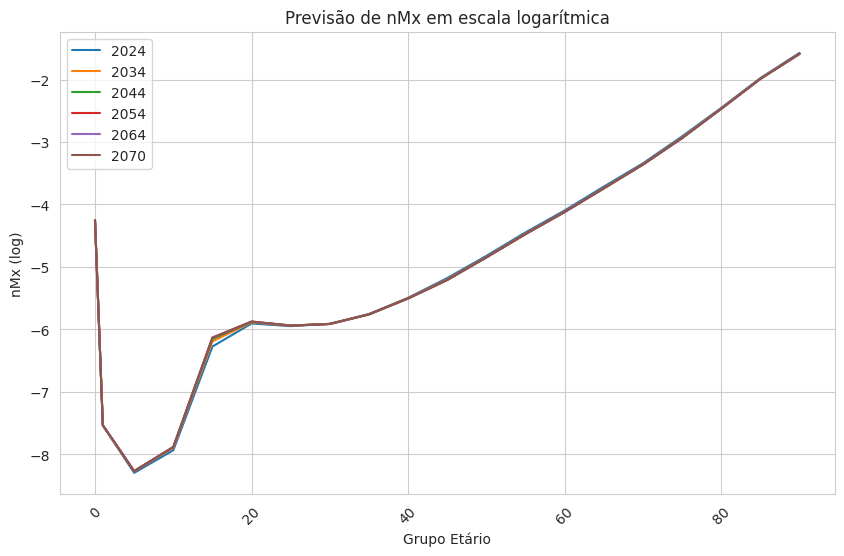

In [36]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2024], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2034], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2044], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2054], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2064], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2070], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [37]:
# Carregar métricas
df_metrics_male

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Masculino,0,0.001080,7.546591,0.001068
1,Brasil,Masculino,1,0.000016,2.650415,0.000015
2,Brasil,Masculino,5,0.000023,8.812187,0.000023
3,Brasil,Masculino,10,0.000040,9.423332,0.000035
4,Brasil,Masculino,15,0.000230,8.956018,0.000176
5,Brasil,Masculino,20,0.000169,4.527873,0.000124
6,Brasil,Masculino,25,0.000172,4.758233,0.000122
7,Brasil,Masculino,30,0.000212,7.006672,0.000188
8,Brasil,Masculino,35,0.000272,8.117417,0.000252
9,Brasil,Masculino,40,0.000434,10.431726,0.000419


In [38]:
# Carregar previsões para mulheres
df_pred_female = pd.read_csv('/content/previsoes_feminino_log.csv')
df_pred_female.head()


,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.011786,0.011277,0.012295
1,Brasil,Feminino,2021,0,0.011751,0.011242,0.012261
2,Brasil,Feminino,2022,0,0.011742,0.011232,0.012251
3,Brasil,Feminino,2023,0,0.011745,0.011235,0.012254
4,Brasil,Feminino,2024,0,0.011751,0.011242,0.012261


In [39]:
# Organizar por ano e grupo etário
df_pred_female = df_pred_female.sort_values(by=['Ano', 'Grupo Etário'])
df_pred_female.head()

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.011786,0.011277,0.012295
51,Brasil,Feminino,2020,1,0.000456,0.000440,0.000472
102,Brasil,Feminino,2020,5,0.000197,0.000190,0.000203
153,Brasil,Feminino,2020,10,0.000243,0.000238,0.000248
204,Brasil,Feminino,2020,15,0.000470,0.000450,0.000491


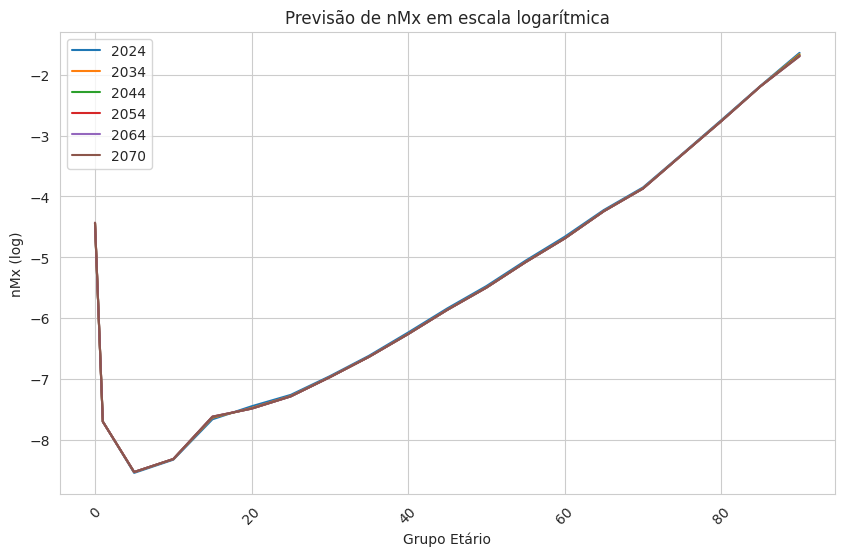

In [40]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2024], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2034], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2044], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2054], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2064], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2070], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [41]:
# Carregar métricas
df_metrics_female

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Feminino,0,0.000849,6.805452,0.000808
1,Brasil,Feminino,1,0.000010,1.710028,0.000008
2,Brasil,Feminino,5,0.000012,5.655664,0.000012
3,Brasil,Feminino,10,0.000011,4.386891,0.000011
4,Brasil,Feminino,15,0.000040,8.157881,0.000039
5,Brasil,Feminino,20,0.000018,2.992103,0.000017
6,Brasil,Feminino,25,0.000040,5.618631,0.000038
7,Brasil,Feminino,30,0.000061,6.424707,0.000059
8,Brasil,Feminino,35,0.000063,4.286212,0.000055
9,Brasil,Feminino,40,0.000105,5.261199,0.000099
